In [3]:
import os
import json
import numpy as np
import osmnx as ox
import networkx as nx
import rasterio
from rasterio.sample import sample_gen
from haversine import haversine, Unit
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import re
from typing import Optional, Union
import contextily as cx
import math
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import imageio
import shapely
from shapely.geometry import LineString

In [4]:
def load_map(point: tuple[float,float]):
    """
    Load OSM trail data for a given region
    Args:
        point: User location (lat, long) used as center for local map
    Returns: The dataset as a NetworkX MultiGraph, the nodes geojson, the edges geojson
    """
    # custom filter to only include walkable segments - see: https://support.alltrails.com/hc/en-us/articles/360019246411-OSM-Derivative-Database-Derivation-Methodology
    cf = '["highway"~"path|track|footway|steps|bridleway|cycleway"]'
    
    # 3.5 km should suffice as bounding box for local area due to cycle route
    dist = 3500

    G = ox.graph_from_point(point, dist=dist, network_type='walk') #custom_filter=cf)

    # Convert Graph to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(G)
    edges = edges[["name", "geometry", "length"]]
    edges["name"] = edges["name"].apply(lambda x: x[0] if type(x) is list else x)

    return G, nodes, edges

Let's take a trip to Odenwald, Germany

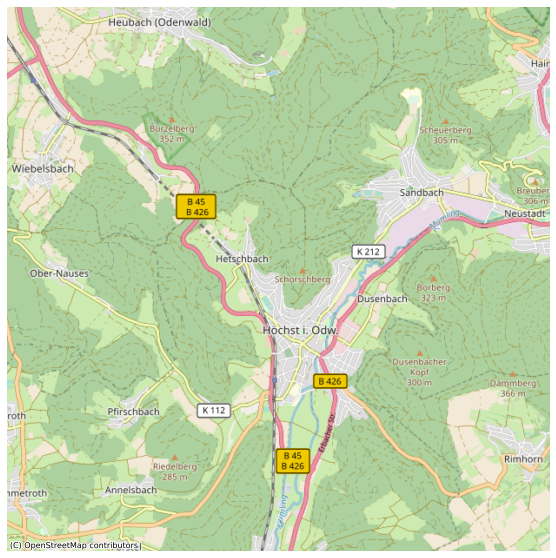

In [5]:
location = tuple([49.807880,8.989109]) 
G, _, gdf = load_map(location)

# Convert the graph to EPSG for visualization with basemap
G_3857 = ox.project_graph(G, to_crs="EPSG:3857")
gdf_3857 = gdf.to_crs(epsg=3857)
ax = gdf_3857.plot(figsize=(10,10), color="none", edgecolor="r", linewidth=3)
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_3857.crs.to_string(), source=cx.providers.OpenStreetMap.DE, zoom=13)
plt.show()

Let's introduce a tile-based value function that is intialized randomly and plot the graph

In [6]:
# Some helper functions for the tile mapping (see https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames)
def deg2num(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
  return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
  n = 2.0 ** zoom
  lon_deg = xtile / n * 360.0 - 180.0
  lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
  lat_deg = math.degrees(lat_rad)
  return (lat_deg, lon_deg)

# Determine the boundaries 
min_long = min(gdf.bounds["minx"])
max_long = max(gdf.bounds["maxx"])
min_lat = min(gdf.bounds["miny"])
max_lat = max(gdf.bounds["maxy"])

# The zoom determines the tile size
zoom = 15

# Trick to determine the number of tiles everywhere on earth from two points
point_a = deg2num(min_lat, min_long, zoom)
point_b = deg2num(max_lat, max_long, zoom)
min_x = min(point_b[0],point_a[0])
min_y = min(point_b[1],point_a[1])
n_tiles_x = abs(point_b[0]-point_a[0])
n_tiles_y = abs(point_b[1]-point_a[1])

# Maps latlong to tile index w.r.t. zoom
def get_idx(lat, long, zoom):
    x, y = deg2num(lat, long, zoom)
    return int((x - min_x) % n_tiles_x), int((y - min_y) % n_tiles_y)

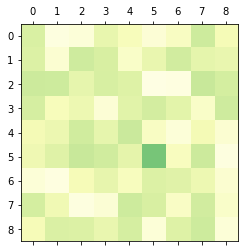

In [7]:
value = np.random.uniform(0, 1, (n_tiles_x, n_tiles_y))*0.3

def set_value(lat, long, v):
    value[get_idx(lat, long, zoom)] = v

def get_value(lat, long):
    return value[get_idx(lat, long, zoom)]


set_value(location[0], location[1], 0.5)

figure = plt.figure()
axes = figure.add_subplot(111)
caxes = axes.matshow(value, cmap=cm.YlGn, interpolation='none', vmin=0, vmax=1)
 
plt.show()

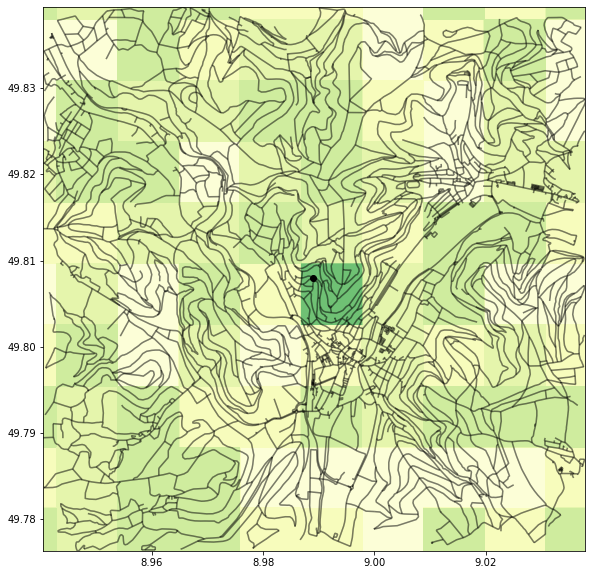

In [8]:
def plot_gdf(G, df: gpd.GeoDataFrame, point=None, value=None, granularity=5, show_axes=False):
    ax = df.plot(figsize=(10, 10), alpha=0.3, edgecolor='k')

    if value is not None:
        x = np.linspace(min_long,max_long,granularity)
        y = np.linspace(min_lat,max_lat,granularity)
        [X,Y] = np.meshgrid(x,y)

        Z = [[value(lat, long) for long in x] for lat in y]
        ax.contourf(x, y, Z, cmap=cm.YlGn, vmin=0, vmax=1)
    
    if point is not None:
        ax.plot(point[1], point[0], color="k", marker="o")

    if not show_axes: 
        ax.set_axis_off()

    return ax

nearest_node_id = ox.nearest_nodes(G, location[1], location[0])
nearest_node = G.nodes[nearest_node_id]
ax = plot_gdf(G, gdf, [nearest_node['y'], nearest_node['x']], get_value, 1000, show_axes=True)
plt.show()

Now let's do some routing

In [9]:
def get_elevation_profile_of_segment(dataset: rasterio.DatasetReader, coords: list[list]):
    """
    Get the elevation profile (distance vs. altitude) of a path segment from the list of coordinates.
    Args:
        dataset: The opened rasterio dataset for the SRTM global topography data. 
        coords: The path coordinates in [[lon1, lat1], [lon2, lat2], ...] format.
    Returns: The distance (in m) and elevation (in m) vectors.
    """
    # coordinates are [lon, lat], flip for rasterio
    coords = [[c[1], c[0]] for c in coords]
    # convert meters to feet and use rasterio.sample.sample_gen to query each point
    elev = [e[0] for e in sample_gen(dataset, coords)]
    d = [0.0]
    for j in range(len(coords) - 1):
        # use haversine distance
        d.append(d[j] + haversine((coords[j][1], coords[j][0]), (coords[j + 1][1], coords[j + 1][0]), Unit.METERS))
    return d, elev

def coords_to_distance_vector(coords: list[list], reverse_coords: bool = True) -> list:
    if reverse_coords: # needs to be [lat, lon]
        coords = [c[::-1] for c in coords]
    return [haversine(coords[i], coords[i+1], Unit.METERS) for i in range(len(coords) - 1)]


def elevation_gain(elev, thresh=70):
    last_pt = elev[0]
    elev_gain = 0
    for e in elev:
        if np.abs(e - last_pt) >= thresh:
            if e - last_pt > 0:
                elev_gain += (e - last_pt)
            last_pt = e
    return elev_gain

def path_to_coords_list(G: nx.Graph, path: list):
    coords_list = []
    for u, v in zip(path[:-1], path[1:]):
        # if there are parallel edges, select the shortest
        data = G.get_edge_data(u, v)
        if "geometry" in data:
            # if geometry attribute exists, add all its coords to list
            xs, ys = data["geometry"].xy
            pts = [[ys[i], xs[i]] for i in range(len(xs))]
            coords_list += pts
        else:
            # otherwise, the edge is a straight line from node to node
            coords_list.append([G.nodes[u]["y"], G.nodes[u]["x"]])
    return coords_list


def path_length(G: nx.Graph, path: list):
    dist = sum([G.edges[path[i], path[i + 1], 0]["length"] for i in range(len(path) - 1)])
    return dist


# We can use a heuristic to deal with many edges by splitting the route cycle into three points (root, anchor, dual)
def find_path(G: nx.Graph, root, target_dist, tol=1.0, min_elev: Optional[Union[int, float]] = None,
                   dataset: Optional[rasterio.DatasetReader] = None):
    # Find appropriate anchor nodes
    anchors = set()
    average_nodes = 0
    var_nodes = 0

    for n in G.nodes():
        if nx.has_path(G, root, n):
            shortest_path = nx.shortest_path(G, root, n)
            if 1/3 * target_dist - tol/3 < path_length(G, shortest_path) < 1/3 * target_dist:
                anchors.add(n)
                average_nodes += len(shortest_path)
                var_nodes += (len(shortest_path) - 13.5)**2             

    average_nodes /= len(anchors)
    var_nodes /= (len(anchors) - 1)

    print("# Anchors", len(anchors))
    print('Nodes Mean: ', average_nodes)
    print('Nodes Std: ', np.sqrt(var_nodes))

    average_nodes = 0
    var_nodes = 0

    duals = set()
    while len(duals) <= 1 or average_nodes > 20:
        duals = set()
        anchor = np.random.choice(tuple(anchors))
    
        for n in anchors:
            if nx.has_path(G, anchor, n):
                shortest_path = nx.shortest_path(G, anchor, n)
                if 1/3 * target_dist - tol/3 < path_length(G, shortest_path) < 1/3 * target_dist:
                    duals.add(n)
                    average_nodes += len(shortest_path)
                    var_nodes += (len(shortest_path) - 13.5)**2    

        if len(duals) <= 1: 
            continue
        average_nodes /= len(duals)
        var_nodes /= (len(duals) - 1)

    print("# Duals: ", len(duals))
    print('Nodes Mean: ', average_nodes)
    print('Nodes Std: ', np.sqrt(var_nodes))
    error = 1e8
    best_path = []

    for n in duals:
        paths = nx.all_simple_paths(G, anchor, n, cutoff=int(average_nodes)) # this is costly (actor part)

        for path in paths:
            path_loop = nx.shortest_path(G, root, anchor, weight="length") + path[1:] + nx.shortest_path(G, n, root, weight="length")[1:]
            dist = path_length(G, path_loop)

            path_diversity = len(set(path_loop)) / len(path_loop)

            e_new = np.abs(dist - target_dist) / path_diversity

            if e_new < error:
                error = e_new
                best_path = path_loop

            if error < tol:
                if min_elev:
                    coords_list = path_to_coords_list(G, path_loop)
                    _, elev = get_elevation_profile_of_segment(dataset, coords_list)
                    elev_gain = elevation_gain(elev)

                    if elev_gain < min_elev:
                        continue
                return best_path

    return best_path

In [18]:
nearest_node_id = ox.nearest_nodes(G, location[1], location[0])
distance_target = 8000 # 10k steps are roughly 8km

with rasterio.open("/run/media/daedalus/6F60B9022EADDF79/Perfect10k/SRTM_GL3_srtm.vrt") as dataset:
            pt = find_path(G, nearest_node_id, int(distance_target), tol=1000, dataset=dataset)

pl = path_length(G, pt)

print("")
print("Route length: ", pl)

# Anchors 88
Nodes Mean:  19.397727272727273
Nodes Std:  7.701320979389588
# Duals:  4
Nodes Mean:  14.25
Nodes Std:  3.696845502136472

Route length:  7775.442999999999


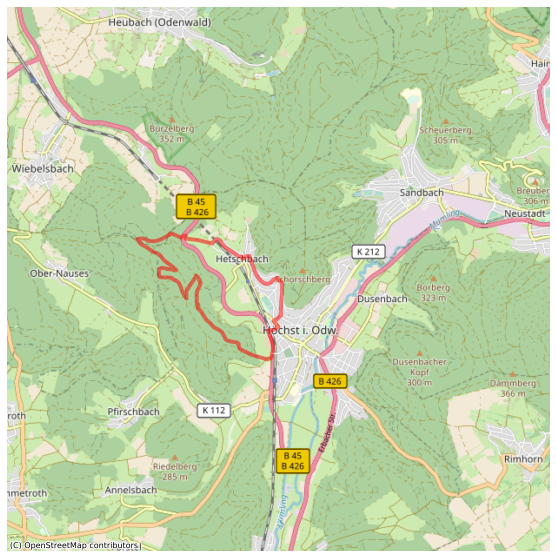

In [19]:
def plot_route(G_3857, gdf_3857, pt):
    ax = gdf_3857.plot(figsize=(10,10), color="none", edgecolor="r", linewidth=3)
    ax.set_axis_off()
    cx.add_basemap(ax, crs=gdf_3857.crs.to_string(), source=cx.providers.OpenStreetMap.DE, zoom=13)
    fig, ax = ox.plot_graph_route(G_3857, pt, orig_dest_size=0, route_alpha=0.5, route_linewidth=4, node_size=0, ax=ax)
    return fig, ax

plot_route(G_3857, gdf_3857, pt)
plt.show()

Let's create a neat animation of the computed route:

In [ ]:
# Store route animation images
filenames = []
for i, e in enumerate(pt, start=1):
    fig, ax = plot_route(G_3857, gdf_3857, pt[:i])
    
    filename = f"./route_animation/img_{i}.png"
    filenames.append(filename)

    fig.savefig(filename, bbox_inches="tight")
    
# build gif
with imageio.get_writer('./route_animation/route.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

![](./route_animation/route.gif)

Let's export the route to GPX so we can use it with a navigation app (e.g. OsmAnd, Google Maps)

In [21]:
def export_route(G, pt, tmp_fp):
    """ Export route to gpx format to use for navigation (OsmAnd, Google Maps)"""
    points = path_to_coords_list(G, pt)
    pts_rev = [(p[1], p[0]) for p in points]
    geom = LineString(pts_rev)
    gpd.GeoDataFrame([geom], columns=["geometry"]).to_file(tmp_fp)
    with open(tmp_fp, "r") as f:
        gpx = f.read()

export_route(G, pt, f"route.gpx")